# Fundamentals of Machine Learning - Exercise 4
Dominique Cheray & Jacqueline Wagner

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import heapq
import math

## 1 Data Generation with Naive Bayes

(120000, 9, 9)
(120000,)
(120000, 81)


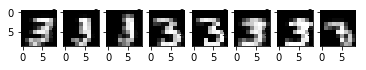

In [2]:
f = h5py.File("digits.h5")
images = f["images"].value
labels = f["labels"].value
f.close()
print(images.shape)
print(labels.shape)
# reshape the images to a feature array
features = np.reshape(images, (120000, 81))
print(features.shape)

# pick all threes and visualize eight of them
threesimg = images[labels == 3]
threesfeat = features[labels == 3]
threeslabel = labels[labels == 3]
ninesfeat = features[labels == 9]
fig = plt.figure()
for i in range(1,9):
    fig.add_subplot(1, 8, i)
    plt.imshow(threesimg[i], cmap="Greys_r")
plt.show()

In [3]:
# naive bayes from last exercise
def fit_naive_bayes(features, labels, bincount=0):
    unique_labels = np.unique(labels)
    N = len(features)
    L = bincount
    histograms = []
    binning = []
    # if no bincount is given determine it according to freedman diaconis
    if bincount == 0:
        iqrs = stats.iqr(features, axis=0)
        delta_x = iqrs[:] * 2.0 / (N ** (1.0/3.0))
        delta_x[delta_x == 0] = np.max(features)
        nr_bins = np.ceil((np.max(features, axis=0) - np.min(features, axis=0)) / delta_x)
        L = int(np.mean(nr_bins))
    for label in unique_labels:
        cl = features[labels == label]
        # adapt delta_x to bincount (either given or determined by freedman diaconis)
        delta_x = ((np.max(cl, axis=0) - np.min(cl, axis=0)) / (L-1))
        delta_x[delta_x == 0] = np.max(cl)
        lower_bound = np.min(cl, axis=0)
        binshape = np.zeros((len(features[0]), 2))
        binshape[:, 0] = lower_bound
        binshape[:, 1] = delta_x
        binning.append(binshape)
        # assign a bin nr to every feature of every instance of this class
        bins = np.floor((cl - lower_bound)/delta_x).astype(int)
        hist = np.zeros((len(cl[0]), (L)))
        for i in range(len(cl[0])):
            # for every feature fill the bins of the histogram
            # with the probability for x in bin
            values, counts = np.unique(bins[:, i], return_counts=True)
            hist[i][values] = counts / (len(cl))
        histograms.append(hist)
    histograms = np.asarray(histograms)
    binning = np.asarray(binning)
    return histograms, binning

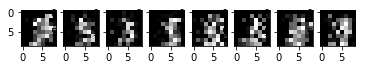

In [4]:
def sample_naive_bayes(histograms, binning):
    ql = np.cumsum(histograms[0], axis=1)
    # generate random ts for every pixel
    t = np.random.rand(len(histograms[0]))
    # for every pixel select a bin
    smallest_l = np.argmax(ql >= np.expand_dims(t, axis=1), axis=1)
    # determine bounds for unifor distribution
    # lower bound = lower bound of first bin + (binwidth * (binnumber+ 1))
    # binnumber +1 because bins start at zero
    lower_boud = binning[0, :, 0] + binning[0, :, 1] * (smallest_l + 1)
    # upper bound = lower bound + binwidth
    upper_bound = lower_boud + binning[0, :, 1]
    # sample pixels from uniform distribution
    img = np.random.uniform(lower_boud, upper_bound)
    # reshape flat image to a 9x9 image and return it
    return img.reshape(9, 9)


# fit the bayes on the threes
hist, binning = fit_naive_bayes(threesfeat, threeslabel)
# now generate eight new threes and show them
fig = plt.figure()
for i in range(1, 9):
    img = sample_naive_bayes(hist, binning)
    fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap="Greys_r")
plt.show()
# with lots of imagination you might see that these are new threes

## 2 Data Generation and Classification with Density Trees
### 2.1 Train Tree by Error Minimization

In [5]:
# class to build the density tree
class Tree():
    def __init__(self, parent, N, N_l, V_l, split_feature, split_threshold):
        self.parent = parent
        self.left = None
        self.right = None
        self.split_threshold = split_threshold
        self.split_feature = split_feature
        self.N = N
        self.N_l = N_l
        self.V_l = V_l
        self.p_l = N_l / (N * V_l)
        # probabilities are  needed for sampling later
        self.probability = N_l / N
        self.probability_left = 0
        self.probability_right = 0


# class for the leafs
# when new leaf is created its best split is determined
class Leaf():
    def __init__(self, parent, features, N, score_fct):
        self.parent = parent
        self.features = features
        self.N = N
        self.N_l = len(features)
        self.probability = self.N_l / N
        # get the min and max of every feature
        mins = np.min(features, axis=0)
        maxs = np.max(features, axis=0)
        # calculate 11 equally spaced thresholds per feature within min and max of that feature
        # 11 instead of 10 beacause first will always be the min of that feature and will be skipped
        # later
        thresholds = np.array([np.linspace(i, j, num=11, endpoint=False) for i, j in zip(mins, maxs)])
        # if there are zeros in mins or maxs set them to one otherwise volume cannot be calculated
        mins[mins == 0] = 1
        maxs[mins == 0] = 1
        self.V_l = mins.dot(maxs)
        self.p_l = self.N_l / (N * self.V_l)
        # set score for best split to minus infinity
        self.best_score = -math.inf
        eps = 1e-16
        # for every feature and all of its thresholds determine splits
        for i in range(thresholds.shape[0]):
            # skip first entry of thresholds because it will always be the min of that features
            for j in range(1, thresholds.shape[1]):
                left_feats = features[features[:, i] <= thresholds[i, j]]
                right_feats = features[features[:, i] > thresholds[i, j]]
                N_left = len(left_feats)
                N_right = len(right_feats)
                # if split leads to empty leaf skip it
                if N_left < 1 or N_right < 1:
                    continue
                V_left = (np.min(left_feats, axis=0).dot(np.max(left_feats, axis=0)))
                V_right = (np.min(right_feats, axis=0).dot(np.max(right_feats, axis=0)))
                # if Volume of split to small skip it
                if V_left < eps or V_right < eps:
                    continue
                p_left = N_left / (N * V_left)
                p_right = N_right / (N * V_right)
                # if probability density of one of the splits is to small skip it
                if p_left < eps or p_right < eps:
                    continue
                # check which score function has to be used
                if score_fct == 1:
                    score = np.square(p_left) * V_left + np.square(p_right) * V_right - np.square(self.p_l) * self.V_l
                else:
                    score = (np.square(N_right * self.V_l - self.N_l * V_left)) / V_left * (self.V_l - V_left)
                # if score of this split is better than previous splits
                # save it
                if score > self.best_score:
                    self.best_score = score
                    self.split_feature = i
                    self.split_threshold = thresholds[i][j]
                    self.left_feats = left_feats
                    self.right_feats = right_feats

    # function to tell heapq to sort by best_score
    def __lt__(self, other):
        return self.best_score > other.best_score

In [6]:
def fit_density_tree1(features, bincount=0):
    queue = []
    Tau = 7
    N = len(features)
    if bincount == 0:
        # calculate # of bins needs to be an int
        L = (int)(Tau * (N ** (1.0/3.0)))
    else:
        # use given bincount
        L = bincount
    # first leaf are just all feature
    root_leaf = Leaf(None, features, N, 1)
    heapq.heappush(queue, root_leaf)
    # from 1 to  number of leafs - 1 (as given in the lecture)
    for t in range(1, L):
        # get leaf with best score
        next_split = heapq.heappop(queue)
        # make a treenode out of the leaf
        tree_node = Tree(next_split.parent, N, next_split.N_l, next_split.V_l,
                         next_split.split_feature, next_split.split_threshold)
        # first split has no parent
        if next_split.parent:
            if next_split.parent.left == next_split:
                next_split.parent.left = tree_node
            else:
                next_split.parent.right = tree_node
        # now take the left and right split of that leaf and hang them on the tree node
        left = Leaf(tree_node, next_split.left_feats, N, 1)
        right = Leaf(tree_node, next_split.right_feats, N, 1)
        tree_node.left = left
        tree_node.right = right
        # update probabilities of tree node
        tree_node.probability_left = left.probability
        tree_node.probability_right = right.probability
        # and push them on the queue
        heapq.heappush(queue, left)
        heapq.heappush(queue, right)

    root = tree_node
    while root.parent:
        root = root.parent

    return root


tree1 = fit_density_tree1(threesfeat)

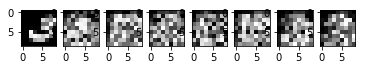

In [19]:
def sample_density_tree(density_tree):
    t = np.random.uniform(0, 1)
    node = density_tree
    # while node is not a leaf descend 
    while isinstance(node, Tree):
        if t <= node.probability_left:
            node = node.left
        else:
            t = t - node.probability_left
            node = node.right
    img = np.random.uniform(np.min(node.features, axis=0), np.max(node.features, axis=0))
    return img.reshape(9, 9)


fig = plt.figure()
for i in range(1, 9):
    img = sample_density_tree(tree1)
    fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap="Greys_r")
plt.show()

### 2.2 Train Tree by Maximizing Non-Uniformity

In [8]:
# the same as fit density_tree2 just with the other score function
# not elegant, but it was faster than to refactor the Tree and the Leaf
# to be beautiful objects with convenient methods
def fit_density_tree2(features, bincount=0):
    queue = []
    Tau = 7
    N = len(features)
    if bincount == 0:
        # calculate # of bins needs to be an int
        L = (int)(Tau * (N ** (1.0/3.0)))
    else:
        # use given bincount
        L = bincount
    # first leaf are just all feature
    root_leaf = Leaf(None, features, N, 2)
    heapq.heappush(queue, root_leaf)
    # from 1 to  number of leafs - 1 (as given in the lecture)
    for t in range(1, L):
        # get leaf with best score
        next_split = heapq.heappop(queue)
        # make a treenode out of the leaf
        tree_node = Tree(next_split.parent, N, next_split.N_l, next_split.V_l,
                         next_split.split_feature, next_split.split_threshold)
        # first split has no parent
        if next_split.parent:
            if next_split.parent.left == next_split:
                next_split.parent.left = tree_node
            else:
                next_split.parent.right = tree_node
        # now take the left and right split of that leaf and hang them on the tree node
        left = Leaf(tree_node, next_split.left_feats, N, 2)
        right = Leaf(tree_node, next_split.right_feats, N, 2)
        tree_node.left = left
        tree_node.right = right
        # update probabilities of tree node
        tree_node.probability_left = left.probability
        tree_node.probability_right = right.probability
        # and push them on the queue
        heapq.heappush(queue, left)
        heapq.heappush(queue, right)

    root = tree_node
    while root.parent:
        root = root.parent

    return root

tree2 = fit_density_tree2(threesfeat)

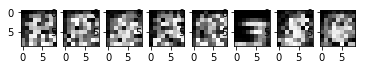

In [21]:
fig = plt.figure()
for i in range(1, 9):
    img = sample_density_tree(tree2)
    fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap="Greys_r")
plt.show()

### 2.3 Tree-Based Classification

In [15]:
def predict_density_trees(test_features, tree_for_3, tree_for_9):
    probabilities = np.zeros((2, len(test_features)))
    # for every sample 
    for i in range(test_features.shape[0]):
        # checkt probability for three
        node = tree_for_3
        # while node is not a leaf descend further into tree
        while isinstance(node, Tree):
            if test_features[i][node.split_feature] < node.split_threshold:
                node = node.left
            else:
                node = node.right
        # finally get probability for sample in this class
        probabilities[0][i] = np.log(node.p_l)
        # now check for nine
        node = tree_for_9
        # while node is not a leaf:
        while isinstance(node, Tree):
            if test_features[i][node.split_feature] < node.split_threshold:
                node = node.left
            else:
                node = node.right
        probabilities[1][i] = np.log(node.p_l)
    predicted_labels = np.argmax(probabilities, axis=0)
    predicted_labels[predicted_labels == 0] = 3
    predicted_labels[predicted_labels == 1] = 9
    return predicted_labels

# train the trees by Error Minimization
three_tree1 = fit_density_tree1(threesfeat)
nine_tree1 = fit_density_tree1(ninesfeat)

# train the trees by Maximizin Non-Uniformity
three_tree2 = fit_density_tree2(threesfeat)
nine_tree2 = fit_density_tree2(ninesfeat)

In [16]:
# useful function to compute and print out the confusion matrix
def confusion_matrix(predicted, true, print_result=True):
    # all possible classes in training and testing data
    classes = np.unique(np.concatenate([true, predicted]))
     
    # for each matrix entry in row c_t, column c_p, count
    # for how many examples is the true label c_t and the predicted label c_p.
    matrix = [[np.sum((true == c_t) * (predicted == c_p)) / np.sum(true == c_t) 
                                     for c_t in classes] for c_p in classes]
    if print_result:
        print('Class | ' +' |'.join(['%5d'%(c) for c in classes])) 
        for c, row in zip(classes, matrix):
            print('------+-' + '+'.join(['------' for c in classes]))
            print('%5d | '%(c) + '|'.join(['%5.1f%%'%(100.*r) for r in row]))
        print()
        
    return matrix 

In [17]:
# load the testset and filter it for threes and nines
f = h5py.File("digits_test.h5")
test_images = f["images"].value
test_labels = f["labels"].value
f.close()
print(test_images.shape)
print(test_labels.shape)
# reshape the images to a feature array
test_features = np.reshape(test_images, (100000, 81))
print(test_features.shape)
filter_mask = (test_labels == 3) | (test_labels == 9)
test_features = test_features[filter_mask]
test_labels = test_labels[filter_mask]
print(test_features.shape)

# use both tree versions for prediction
tree_prediction1 = predict_density_trees(test_features, three_tree1, nine_tree1)
tree_prediction2 = predict_density_trees(test_features, three_tree2, nine_tree2)
print('Confusion matrix for trees using Error Minimization')
conf_mat1 = confusion_matrix(tree_prediction1, test_labels)
print('Confusion matrix for trees using Maximization of Non-Uniformity')
conf_mat2 = confusion_matrix(tree_prediction2, test_labels)

(100000, 9, 9)
(100000,)
(100000, 81)
(20190, 81)
Confusion matrix for trees using Error Minimization
Class |     3 |    9
------+-------+------
    3 |  72.8%| 57.5%
------+-------+------
    9 |  27.2%| 42.5%

Confusion matrix for trees using MAximization of Non-Uniformity
Class |     3 |    9
------+-------+------
    3 |  52.1%| 29.3%
------+-------+------
    9 |  47.9%| 70.7%



In our case the density tree does not work better. He makes more errors in classification than our naive Bayes implementation did. And the images generated by naive Bayes are better. Most of the images generated by the trees just look like random noise. If one tries often enough sometimes at least one looks okay.

## 3 Data Generation with a Multi-dimensional Gaussian

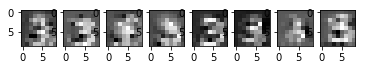

In [13]:
def fit_gaussian(features):
    mu = np.mean(features, axis=0)
    covmat = np.cov(features, rowvar=False)
    return mu, covmat

# fit the gaussian on the threes
mu, covmat = fit_gaussian(threesfeat)
# now generate eight new threes and show them
fig = plt.figure()
for i in range(1, 9):
    img = np.random.multivariate_normal(mu, covmat).reshape(9, 9)
    fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap="Greys_r")
plt.show()